***
# ISOM3360 Data Mining for Business Analytics
## Group 23 Project Code - Credit Card Defaultee Analysis
### Part 2.3 - Naive Bayes Classifier
***

Name: LAM, Ho Chit  
ITSC: hclamao  
SID: 20607878

Name: LEE, Ho Wan Owen  
ITSC: hwolee  
SID: 20604852

Name: LEE, Wai Chung  
ITSC: wcleeaj  
SID: 20702733

### Workflow of this notebook (TBC)

1. Explore features and characteristics of dataset
2. Drop columns of low data quality (e.g. large amounts of empty values)
3. Determine $k$ columns to keep in the dataset (feature selection)
4. Perform one-hot encoding
5. Split into training and testing sets
6. Perform data cleaning
   - Dealing with missing values
7. Perform data standardization / normalization
8. Export preprocessed data to .csv files at `./data_preprocessed/`

### Naive Bayes
we will use all the train data (891 examples) to construct the tree and evaluate the model

## Data preprocessing (con't)

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_rows', 500)

In [7]:
#Load cleaned data
raw_df = pd.read_csv('../data_preprocessed/raw2nb.csv',index_col = 'SK_ID_CURR')

### Dealing with missing values

In [8]:
raw_df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(raw_df['OBS_30_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)
raw_df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(raw_df['DEF_30_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)
raw_df['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(raw_df['OBS_60_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)
raw_df['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(raw_df['DEF_60_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)
raw_df['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(raw_df['AMT_REQ_CREDIT_BUREAU_HOUR'].mode()[0],inplace=True)
raw_df['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(raw_df['AMT_REQ_CREDIT_BUREAU_DAY'].mode()[0],inplace=True)
raw_df['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(raw_df['AMT_REQ_CREDIT_BUREAU_WEEK'].mode()[0],inplace=True)
raw_df['AMT_REQ_CREDIT_BUREAU_MON'].fillna(raw_df['AMT_REQ_CREDIT_BUREAU_MON'].mode()[0],inplace=True)
raw_df['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(raw_df['AMT_REQ_CREDIT_BUREAU_QRT'].mode()[0],inplace=True)
raw_df['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(raw_df['AMT_REQ_CREDIT_BUREAU_YEAR'].mode()[0],inplace=True)
raw_df['DAYS_LAST_PHONE_CHANGE'].fillna(raw_df['DAYS_LAST_PHONE_CHANGE'].mean(),inplace=True)
raw_df['EXT_SOURCE_2'].fillna(raw_df['EXT_SOURCE_2'].mean(),inplace=True)
raw_df['EXT_SOURCE_3'].fillna(raw_df['EXT_SOURCE_3'].mean(),inplace=True)

In [9]:
#Drop the columns that has number of missing values >100000
raw_df = raw_df.dropna(axis=1)

In [10]:
#Save the data to a new file
raw_df.to_csv('raw_no_missingNB.csv')

In [11]:
raw_df.isnull().sum()

TARGET                                               0
NAME_CONTRACT_TYPE                                   0
CNT_CHILDREN                                         0
AMT_INCOME_TOTAL                                     0
AMT_CREDIT                                           0
AMT_ANNUITY                                          0
AMT_GOODS_PRICE                                      0
REGION_POPULATION_RELATIVE                           0
DAYS_BIRTH                                           0
DAYS_EMPLOYED                                        0
DAYS_REGISTRATION                                    0
DAYS_ID_PUBLISH                                      0
FLAG_MOBIL                                           0
FLAG_EMP_PHONE                                       0
FLAG_WORK_PHONE                                      0
FLAG_CONT_MOBILE                                     0
FLAG_PHONE                                           0
FLAG_EMAIL                                           0
OCCUPATION

## Perform one-hot encoding

In [12]:
raw_df = pd.get_dummies(raw_df, columns=['NAME_CONTRACT_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE'],drop_first = False)

#p.s. for Naive Bayes Classification, set drop_first = False. Also, no need modification on MALE and FEMALE.

### Select 20 predictors used (same as in decision tree)

In [14]:
columns = ['EXT_SOURCE_3','EXT_SOURCE_2','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','NAME_EDUCATION_TYPE_Higher education','NAME_INCOME_TYPE_Working','DAYS_LAST_PHONE_CHANGE','NAME_EDUCATION_TYPE_Secondary / secondary special','CODE_GENDER_M','DAYS_ID_PUBLISH','NAME_INCOME_TYPE_Pensioner','REG_CITY_NOT_WORK_CITY','DAYS_REGISTRATION','REG_CITY_NOT_LIVE_CITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE','NAME_CONTRACT_TYPE_Revolving loans','LIVE_CITY_NOT_WORK_CITY','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET']
raw_df = raw_df[columns]
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 21 columns):
EXT_SOURCE_3                                         307511 non-null float64
EXT_SOURCE_2                                         307511 non-null float64
DAYS_BIRTH                                           307511 non-null int64
REGION_RATING_CLIENT_W_CITY                          307511 non-null int64
NAME_EDUCATION_TYPE_Higher education                 307511 non-null int64
NAME_INCOME_TYPE_Working                             307511 non-null int64
DAYS_LAST_PHONE_CHANGE                               307511 non-null float64
NAME_EDUCATION_TYPE_Secondary / secondary special    307511 non-null int64
CODE_GENDER_M                                        307511 non-null int64
DAYS_ID_PUBLISH                                      307511 non-null int64
NAME_INCOME_TYPE_Pensioner                           307511 non-null int64
REG_CITY_NOT_WORK_CITY                               

### Balancing the data by downscalling

In [15]:
print("Out of ", raw_df.shape[0], " customers, only", raw_df['TARGET'].sum(), " customers default!")

Out of  307511  customers, only 24825  customers default!


In [16]:
balanced_train = raw_df.drop(raw_df[raw_df.TARGET==0].index[0:257861])
print("Out of ", balanced_train.shape[0], " customers, ", balanced_train['TARGET'].sum(), " customers default!")

Out of  49650  customers,  24825  customers default!


### Normalization

In [17]:
numerlist = []

for col in raw_df:
    if raw_df[col].nunique() > 2:
        numerlist.append(col)
    # print(f"{col} has unique values of {raw_df[col].unique()}" if raw_df[col].nunique() < 3 else f"{col} is definitely not dummy.")
        
numerlist

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

In [18]:
# normalization

for i in numerlist:
    amt4max = balanced_train[i].max()
    amt4min = balanced_train[i].min()
    balanced_train[i] = (balanced_train[i] - amt4min) / (amt4max - amt4min)
balanced_train.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,DAYS_LAST_PHONE_CHANGE,NAME_EDUCATION_TYPE_Secondary / secondary special,CODE_GENDER_M,DAYS_ID_PUBLISH,...,REG_CITY_NOT_WORK_CITY,DAYS_REGISTRATION,REG_CITY_NOT_LIVE_CITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,NAME_CONTRACT_TYPE_Revolving loans,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET
count,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,...,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000,49650.000000
mean,0.521109,0.546019,0.552565,0.539476,0.206244,0.560302,0.786139,0.744209,0.382276,0.538404,...,0.263243,0.792387,0.095811,0.118231,0.271758,0.082377,0.198449,0.027685,0.019638,0.500000
std,0.208307,0.242866,0.246220,0.252388,0.404612,0.496355,0.191244,0.436309,0.485948,0.243818,...,0.440397,0.149787,0.294334,0.085527,0.180882,0.274940,0.398836,0.079704,0.065490,0.500005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380107,0.360559,0.352951,0.500000,0.000000,0.000000,0.645099,0.000000,0.000000,0.322467,...,0.000000,0.689419,0.000000,0.049383,0.126766,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.569889,0.602987,0.576892,0.500000,0.000000,1.000000,0.837048,1.000000,0.000000,0.511803,...,0.000000,0.812805,0.000000,0.102132,0.253810,0.000000,0.000000,0.000000,0.000000,0.500000
75%,0.654145,0.744940,0.759490,0.500000,0.000000,1.000000,0.942727,1.000000,1.000000,0.749599,...,1.000000,0.919007,0.000000,0.158249,0.359278,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Building the NB model

In [19]:
import sys
sys.path.insert(0, "..")

In [23]:
import pandas as pd
import numpy as np
#Import Gaussian Naive Bayes model from sklearn
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

#### Step 3: Data Splitting

In [21]:
from utils.constants import random_state
from sklearn.model_selection import train_test_split
# Split the data into training and test.

y = balanced_train[['TARGET']]
X = balanced_train.drop(columns=['TARGET'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

#### NB Gaussian

In [24]:
# import cross validation
from sklearn.model_selection import cross_val_predict, cross_val_score

score = cross_val_score(gnb,X_train,y_train,cv=5).mean()
score

C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

0.6435800604229607

In [25]:
pred_y = cross_val_predict(gnb,X_train,y_train,cv=10)
pred_y

C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

# Do majority-class prediction (not accept: 0) -> Benchmark model
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.htm
pred_val_maj = np.zeros((X_train.shape[0],),dtype=int)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy of Benchmark Model:","\n", accuracy_score(y_train, pred_val_maj, normalize=True, sample_weight=None))
print("Accuracy of Naive Bayes Model:","\n", accuracy_score(y_train, pred_y, normalize=True, sample_weight=None))

Accuracy of Benchmark Model: 
 0.49987411883182276
Accuracy of Naive Bayes Model: 
 0.6435548841893253


In [27]:
# print the confusion matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
print("Confusion Matrix of Benchmark Model:", "\n", confusion_matrix(y_train, pred_val_maj))
print("Confusion Matrix of Naive Bayes Model:", "\n", confusion_matrix(y_train, pred_y))

Confusion Matrix of Benchmark Model: 
 [[19855     0]
 [19865     0]]
Confusion Matrix of Naive Bayes Model: 
 [[12973  6882]
 [ 7276 12589]]


In [28]:
# print the classification report with precision, recall
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print("Classification Report of Benchmark Model:", "\n", classification_report(y_train, pred_val_maj))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_train, pred_y))

Classification Report of Benchmark Model: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     19855
           1       0.00      0.00      0.00     19865

    accuracy                           0.50     39720
   macro avg       0.25      0.50      0.33     39720
weighted avg       0.25      0.50      0.33     39720

Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.64      0.65      0.65     19855
           1       0.65      0.63      0.64     19865

    accuracy                           0.64     39720
   macro avg       0.64      0.64      0.64     39720
weighted avg       0.64      0.64      0.64     39720



C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
# train model using all training dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.fit
gnb.fit(X_train, y_train)

C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# test model (output probability estimate)
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.predict_proba
pred_prob = gnb.predict_proba(X_test)

# show the probability of belonging to class 0 and class 1
pred_prob

array([[0.99351646, 0.00648354],
       [0.40999289, 0.59000711],
       [0.40853247, 0.59146753],
       ...,
       [0.13769627, 0.86230373],
       [0.32042201, 0.67957799],
       [0.22315791, 0.77684209]])

In [31]:
pred_prob[:,1]

array([0.00648354, 0.59000711, 0.59146753, ..., 0.86230373, 0.67957799,
       0.77684209])

In [32]:
# y is the true label, pred_prob[:,1] measures the predicted probability of belonging to class 1 (which is defined as positive class)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1], pos_label=1)

In [33]:
# Aread under ROC curve
roc_auc=auc(fpr,tpr)
roc_auc

0.6903456626857921

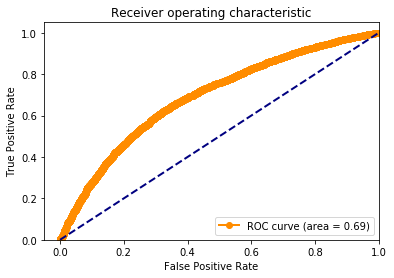

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Grid Search and Cost Analysis

In [43]:
#import homemade cost function
import sys
sys.path.insert(0, '..')
from utils.custom_cost import custom_loss
# create try_grid
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=10)
}

In [44]:
from sklearn.model_selection import GridSearchCV

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1, 
                            scoring="roc_auc")
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s


GaussianNB(priors=None, var_smoothing=0.01)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
nbModel_grid.best_score_

0.6897729276133595

In [46]:
best_model = GaussianNB(var_smoothing=0.01)

In [47]:
best_model.fit(X_train,y_train)

C:\Users\wclee\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=0.01)

In [48]:
y_predict = best_model.predict(X_test)

In [49]:
print("Accuracy:",accuracy_score(y_test, y_predict, normalize=True, sample_weight=None))
print("Confusion Matrix", '\n', confusion_matrix(y_test, y_predict))
print("Classification Report:", '\n', classification_report(y_test, y_predict))

Accuracy: 0.6450151057401813
Confusion Matrix 
 [[3195 1775]
 [1750 3210]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.64      0.64      4970
           1       0.64      0.65      0.65      4960

    accuracy                           0.65      9930
   macro avg       0.65      0.65      0.65      9930
weighted avg       0.65      0.65      0.65      9930



### Using economic loss estimation to determine decision threshold

In [50]:
from utils.custom_cost import economic_analysis

In [51]:
# obtain estimated probability of default
y_train_proba = best_model.predict_proba(X_train)

In [52]:
# loop through 10 decision thresholds to determine the optimal threshold
optimal_threshold = 1
optimal_cost = sys.maxsize

# search for optimal threshold on training set
for i in np.linspace(0.25, 0.7, num=19, endpoint=True):
    cost = economic_analysis(y_train, y_train_proba, threshold=i)
    if cost < optimal_cost:
        optimal_threshold = i
        optimal_cost = cost
        
print("Optimal threshold = {0:.3}, at estimated economic loss of ${1}.".format(optimal_threshold, optimal_cost))

The estimated economic cost at decision threshold 0.250 = $63078934
The estimated economic cost at decision threshold 0.275 = $63568914
The estimated economic cost at decision threshold 0.300 = $64245992
The estimated economic cost at decision threshold 0.325 = $64524778
The estimated economic cost at decision threshold 0.350 = $65263214
The estimated economic cost at decision threshold 0.375 = $65670150
The estimated economic cost at decision threshold 0.400 = $66124714
The estimated economic cost at decision threshold 0.425 = $66609986
The estimated economic cost at decision threshold 0.450 = $67246774
The estimated economic cost at decision threshold 0.475 = $68079682
The estimated economic cost at decision threshold 0.500 = $69271210
The estimated economic cost at decision threshold 0.525 = $70255410
The estimated economic cost at decision threshold 0.550 = $71542252
The estimated economic cost at decision threshold 0.575 = $72857168
The estimated economic cost at decision threshol

In [53]:
# obtain optimal economic loss on test set
y_test_proba = best_model.predict_proba(X_test)

economic_analysis(y_test, y_test_proba, threshold=optimal_threshold)

The estimated economic cost at decision threshold 0.250 = $15794626


15794626

### Conclusion and findings

The accuracy of the NB model is higher than the majority classifier. But this model performed worse than the other 2 models.

One of the reasons for the poor behaviour of the Naive Bayes Classifier is that the features seems to be correlated, where the independence assumption doesn't hold.

## This is the end of Part 2.3 Naive Bayes Classifier.